### Importing Libraries & Reading Data

In [68]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [44]:
# set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
# load dataset
fraud_df = pd.read_csv('data/cleaned_fraud_dataset.csv')
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538659 entries, 0 to 538658
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   timestamp                 538659 non-null  object 
 1   amount                    538659 non-null  float64
 2   transaction_type          538659 non-null  object 
 3   merchant_category         538659 non-null  object 
 4   location                  538659 non-null  object 
 5   device_used               538659 non-null  object 
 6   is_fraud                  538659 non-null  bool   
 7   spending_deviation_score  538659 non-null  float64
 8   velocity_score            538659 non-null  int64  
 9   geo_anomaly_score         538659 non-null  float64
 10  payment_channel           538659 non-null  object 
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 41.6+ MB


### Data Preprocessing and Model Architecture

In [46]:
# remove timestamp column (no predictive value after feature extraction)
fraud_df.drop('timestamp', axis=1, inplace=True)

In [47]:
# encode categorical variables
categorical_columns = ['transaction_type', 'merchant_category', 'location', 'device_used', 'payment_channel']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    fraud_df[col] = le.fit_transform(fraud_df[col])
    label_encoders[col] = le

In [48]:
# prepare features and target
X = fraud_df.drop('is_fraud', axis=1)
y = fraud_df['is_fraud'].astype(int)

In [49]:
# check class distribution before balancing
print("Original class distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True))

Original class distribution:
0    359106
1    179553
Name: is_fraud, dtype: int64
0    0.666667
1    0.333333
Name: is_fraud, dtype: float64


In [50]:
# split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

70-15-15 split with stratification to maintain class balance


In [51]:
# apply SMOTE to balance training data only
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [52]:
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())
print(pd.Series(y_train_balanced).value_counts(normalize=True))


Class distribution after SMOTE:
1    251374
0    251374
Name: is_fraud, dtype: int64
1    0.5
0    0.5
Name: is_fraud, dtype: float64


In [53]:
# scale features (StandardScaler ensures all features are on same scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [69]:
joblib.dump(scaler, 'models/synthetic_scaler.pkl')

['models/synthetic_scaler.pkl']

In [54]:
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (502748, 9)
Validation set: (80799, 9)
Test set: (80799, 9)


In [55]:
print(f"Feature names: {list(X.columns)}")

Feature names: ['amount', 'transaction_type', 'merchant_category', 'location', 'device_used', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score', 'payment_channel']


In [56]:
# build model
def create_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dropout(0.2),
        
        Dense(8, activation='relu'),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [57]:
model = create_model(X_train_scaled.shape[1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               2560      
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 128)              

- Deep network (6 hidden layers) can capture complex non-linear patterns in PCA features

- Decreasing layer sizes (256→128→64→32→16→8) create a funnel that progressively abstracts 
features

- BatchNormalization stabilizes training and allows higher learning rates

- Dropout layers prevent overfitting on this complex dataset

- Sigmoid output provides probability scores for binary classification

### Model Training

In [58]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

- EarlyStopping prevents overfitting by monitoring validation loss

- ReduceLROnPlateau adaptively reduces learning rate when loss plateaus

In [59]:
# train the model
history = model.fit(
    X_train_scaled, y_train_balanced,
    epochs=100,
    batch_size=1024,
    validation_data=(X_val_scaled, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
491/491 [==============================] - 12s 21ms/step - loss: 0.8320 - accuracy: 0.5095 - val_loss: 0.6954 - val_accuracy: 0.5144 - lr: 0.0010
Epoch 2/100
491/491 [==============================] - 9s 18ms/step - loss: 0.7225 - accuracy: 0.5184 - val_loss: 0.6942 - val_accuracy: 0.5146 - lr: 0.0010
Epoch 3/100
491/491 [==============================] - 10s 21ms/step - loss: 0.7018 - accuracy: 0.5216 - val_loss: 0.6958 - val_accuracy: 0.5038 - lr: 0.0010
Epoch 4/100
491/491 [==============================] - 14s 28ms/step - loss: 0.6917 - accuracy: 0.5294 - val_loss: 0.6938 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 5/100
491/491 [==============================] - 10s 21ms/step - loss: 0.6901 - accuracy: 0.5331 - val_loss: 0.6967 - val_accuracy: 0.5002 - lr: 0.0010
Epoch 6/100
491/491 [==============================] - 11s 22ms/step - loss: 0.6899 - accuracy: 0.5343 - val_loss: 0.6968 - val_accuracy: 0.5001 - lr: 0.0010
Epoch 7/100
491/491 [==============================] 

### Model Evaluation

In [60]:
# evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
test_preds = model.predict(X_test_scaled)
test_preds_binary = (test_preds > 0.5).astype(int)

2525/2525 [==============================] - 7s 3ms/step


In [61]:
# get metrics
test_precision = precision_score(y_test, test_preds_binary)
test_recall = recall_score(y_test, test_preds_binary)
test_f1 = f1_score(y_test, test_preds_binary)
test_auc = roc_auc_score(y_test, test_preds)
test_ap = average_precision_score(y_test, test_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"Test Average Precision: {test_ap:.4f}")

Test Accuracy: 0.5300
Test Precision: 0.3337
Test Recall: 0.4111
Test F1-Score: 0.3683
Test AUC-ROC: 0.4993
Test Average Precision: 0.3322


Metric Interpretation 

- Accuracy (53.00%): Marginally above random chance (50%) - indicates very poor model performance

- Precision (33.37%): Only 1 in 3 predicted frauds are actually fraudulent - extremely high false alarm rate

- Recall (41.11%): Catches only 41% of actual frauds - missing majority of fraud cases

- F1-Score (36.83%): Poor balance between precision and recall, slight improvement over previous run

- AUC-ROC (49.93%): Essentially random performance - model has no discriminative ability

- Average Precision (33.22%): Very poor precision-recall performance, unchanged from previous run

In [62]:
# classification report
print(classification_report(y_test, test_preds_binary))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63     53866
           1       0.33      0.41      0.37     26933

    accuracy                           0.53     80799
   macro avg       0.50      0.50      0.50     80799
weighted avg       0.56      0.53      0.54     80799



- Class 0 (Legitimate): 67% precision, 59% recall - declining performance on majority class

- Class 1 (Fraud): 33% precision, 41% recall - slightly improved fraud detection but still very poor

- Macro average (50%): Confirms model performs at random chance level

- Trade-off pattern: Model catching more frauds but at cost of many more false positives

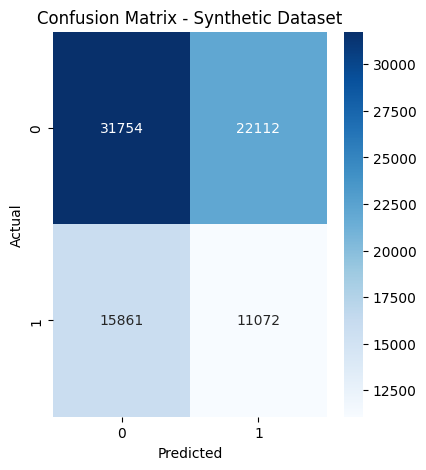

In [67]:
# confusion Matrix 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, test_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Synthetic Dataset')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- True Negatives (31,754): Correctly identified legitimate transactions (59% of legitimate)

- False Positives (22,112): Legitimate transactions incorrectly flagged as fraud (41% of legitimate)

- False Negatives (15,861): Missed fraud cases - 59% of all frauds still missed

- True Positives (11,072): Only 41% of frauds correctly detected

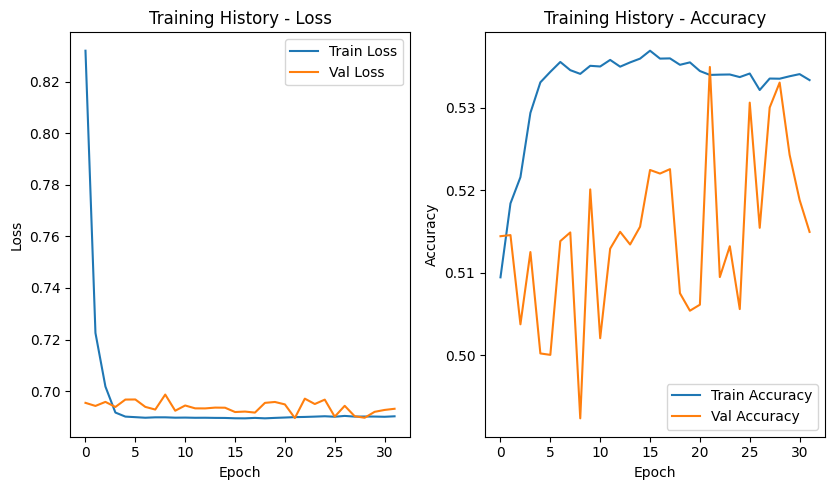

In [64]:
# training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training History - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

- Loss curves: Training loss decreases dramatically but validation loss remains flat and high - severe overfitting

- Accuracy curves: Training accuracy reaches ~54% while validation accuracy fluctuates wildly between 50-55%

- Unstable validation: High variance in validation metrics indicates poor generalization

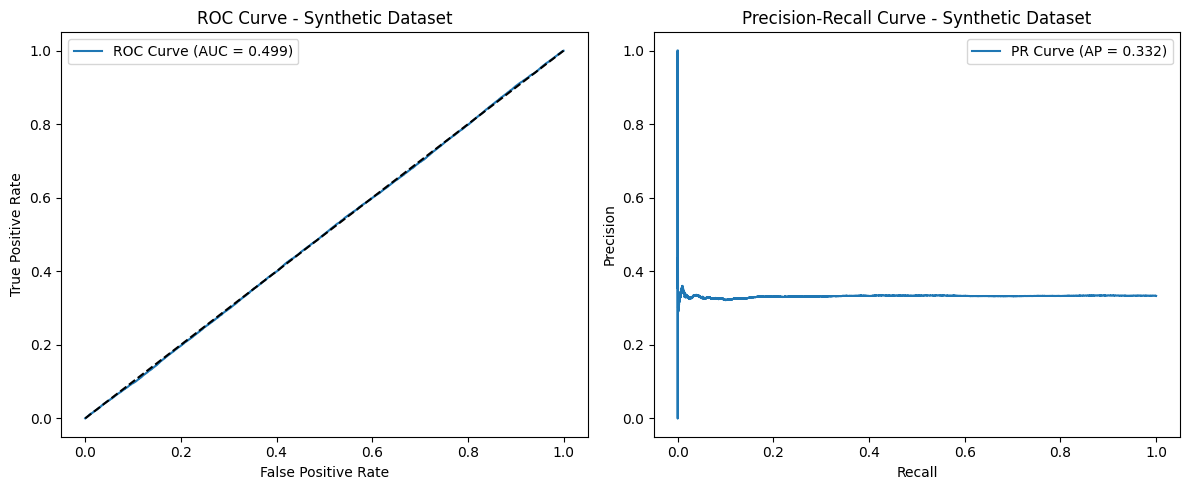

In [65]:
# ROC and PR curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, test_preds)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Synthetic Dataset')
plt.legend()

plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, test_preds)
plt.plot(recall, precision, label=f'PR Curve (AP = {test_ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Synthetic Dataset')
plt.legend()

plt.tight_layout()
plt.show()

- ROC Curve (AUC = 0.499): Remains essentially diagonal - no discrimination capability

- PR Curve (AP = 0.332): Identical flat performance - no improvement in precision-recall trade-off

- No learning: Despite different threshold behavior, fundamental discrimination remains absent

In [66]:
# save the model
model.save('models/synthetic_fraud_model.h5')

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
